In [1]:
try:
    import google.colab
    IN_COLAB = True
    %pip uninstall scikit-learn -y
    %pip install scikit-learn
    %pip install jaxtyping
    from tqdm.notebook import tqdm, trange

    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    %cd /content/gdrive/MyDrive/CCS/_experiment3
except:
    IN_COLAB = False
    from tqdm import tqdm, trange

Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
  Successfully uninstalled scikit-learn-1.4.2
  Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Mounted at /content/gdrive
/content/gdrive/MyDrive/CCS/_experiment3


In [2]:
import os, sys, gc, pickle
sys.path.append("../utils")

import numpy as np
import pandas as pd

import torch as t

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from CCS import CCS
from CRC import CRC
from norm import normalize_burns, normalize_cluster

In [3]:
prompts = pd.read_json("prompts.jsonl", orient="records", lines=True)
labels = prompts["choice_label"].values

model = "llama"
layer = 23

colours = {"unbiased-company": "blue", "unbiased-noncompany": "lightblue",
           "biased-company": "red", "biased-noncompany": "lightcoral"}
legend_elements = [
    mpatches.Patch(facecolor="red", label="Biased:Company"),
    mpatches.Patch(facecolor="lightcoral", label="Biased:Non-company"),
    mpatches.Patch(facecolor="blue", label="Unbiased:Company"),
    mpatches.Patch(facecolor="lightblue", label="Unbiased:Non-company")
]

pca_colour_map = {
    (0, 0): "moccasin", # non-company, choice 1
    (0, 1): "lightblue", # non-company, choice 2
    (1, 0): "orange", # company, choice 1
    (1, 1): "blue", # company, choice 2
}
pca_legend_elements = [
    mpatches.Patch(facecolor="moccasin", label="Non-Company:Choice 1"),
    mpatches.Patch(facecolor="lightblue", label="Non-Company:Choice 2"),
    mpatches.Patch(facecolor="orange", label="Company:Choice 1"),
    mpatches.Patch(facecolor="blue", label="Company:Choice 2")
]

### zero-shot

In [10]:
infile = open(f"logits/biased.pickle", "rb")
biased = pickle.load(infile); infile.close()
biased = np.array([int(x) for x in biased])

infile = open(f"logits/unbiased.pickle", "rb")
unbiased = pickle.load(infile); infile.close()
unbiased = np.array([int(x) for x in unbiased])

out = pd.DataFrame(columns=["company", "non-company"])
for template, preds in zip(["biased", "unbiased"], [biased, unbiased]):
    # accuracy on "company" questions
    c_acc = (preds[:1000] == labels[:1000]).mean()
    # accuracy on non-"company" questions
    nc_acc = (preds[1000:] == labels[1000:]).mean()
    row = [round(c_acc, 2), round(nc_acc, 2)]
    out.loc[template] = row
display(out)

,company,non-company
biased,0.44,0.63
unbiased,0.96,0.98


### logistic regression

In [13]:
out = pd.DataFrame(columns=["company", "non-company"])
perm = t.randperm(len(labels))
for template in ["biased", "unbiased"]:
    pos = t.load(f"activations/{model}/layer{layer}/{template}_correct.pt")[perm]
    neg = t.load(f"activations/{model}/layer{layer}/{template}_incorrect.pt")[perm]
    # 500 samples of "company", 500 of "non-company"
    train_pos, test_pos = t.cat((pos[:500], pos[1000:1500])), t.cat((pos[500:1000], pos[1500:]))
    train_neg, test_neg = t.cat((neg[:500], neg[1000:1500])), t.cat((neg[500:1000], neg[1500:]))
    y_train = np.concatenate([(labels[perm] == 2)[:500], (labels[perm] == 2)[1000:1500]])
    y_test = np.concatenate([(labels[perm] == 2)[500:1000], (labels[perm] == 2)[1500:]])
    lr = LogisticRegression(max_iter=10000)
    lr.fit(train_pos-train_neg, y_train)
    c_acc = lr.score((test_pos-test_neg)[:500], y_test[:500])
    nc_acc = lr.score((test_pos-test_neg)[500:], y_test[500:])
    row = [round(c_acc, 2), round(nc_acc, 2)]
    out.loc[template] = row
display(out)

,company,non-company
biased,1.0,1.0
unbiased,1.0,1.0


### crc-tpc

CRC norm burns
CRC norm burns
CRC norm cluster
CRC norm cluster


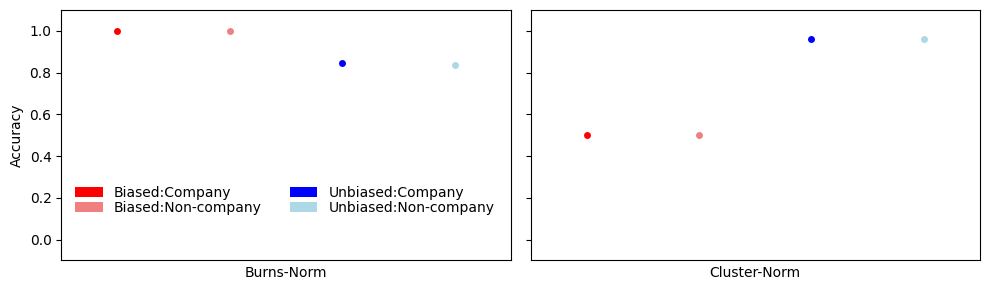

In [12]:
def get_crc(normalize, perm):
    crc = CRC()
    accuracies, templates = [], []
    for template in ["biased", "unbiased"]:
        pos = t.load(f"activations/{model}/layer{layer}/{template}_correct.pt")[perm]
        neg = t.load(f"activations/{model}/layer{layer}/{template}_incorrect.pt")[perm]
        crc.fit(pos, neg, normalize)
        preds = crc.predict(pos, neg)
        c_acc = (preds[:1000] == labels[perm][:1000]).mean()
        nc_acc = (preds[1000:] == labels[perm][1000:]).mean()
        # truth disambiguation only on non-company labels
        if (1-nc_acc) > nc_acc:
            nc_acc = 1-nc_acc
            c_acc = 1-c_acc
        accuracies.extend([c_acc, nc_acc])
        templates.extend([f"{template}-company", f"{template}-noncompany"])
    df = pd.DataFrame()
    df["template"] = templates
    df["accuracy"] = accuracies
    return df

perm = t.randperm(len(labels))
burns = get_crc("burns", perm)
cluster = get_crc("cluster", perm)

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, squeeze=True, figsize=(10, 3))
for ax, df, label in zip(axs, [burns, cluster], ["Burns-Norm", "Cluster-Norm"]):
    sns.stripplot(x="template", y="accuracy", data=df, ax=ax, palette=colours, hue="template", marker="o")
    ax.set_xticks([], [])
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel(label)
axs[0].set_ylabel("Accuracy")
plt.figlegend(handles=legend_elements, loc="lower left", ncol=2, labelspacing=0.1, borderaxespad=5., frameon=False, fontsize="medium")
plt.tight_layout()
plt.show()

### pca

In [4]:
company_labels = [1]*1000 + [0]*1000
choice_labels = [x==2 for x in labels]
colours = [pca_colour_map[(l1, l2)] for l1, l2 in zip(company_labels, choice_labels)]

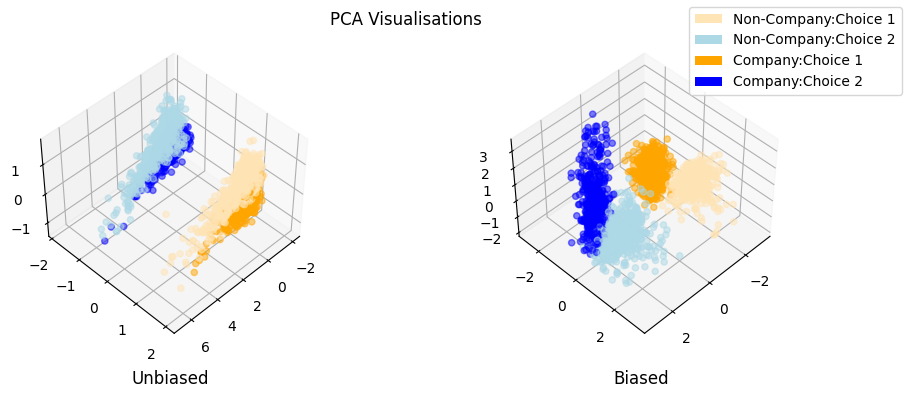

In [8]:
fig = plt.figure(figsize=(10, 4))
for i, template in enumerate(["unbiased", "biased"]):
    pos = t.load(f"activations/{model}/layer{layer}/{template}_correct.pt")
    neg = t.load(f"activations/{model}/layer{layer}/{template}_incorrect.pt")
    pca = PCA(n_components=3)
    X = pca.fit_transform(pos - neg)
    ax = fig.add_subplot(1, 2, i+1, projection="3d")
    ax.view_init(elev=45, azim=45)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.5, c=colours)
    title = f"{template[0].upper()}{template[1:]}"
    ax.set_title(title, y=0, pad=-25, verticalalignment="top")
plt.suptitle("PCA Visualisations")
plt.figlegend(handles=pca_legend_elements)
plt.tight_layout()
plt.show()

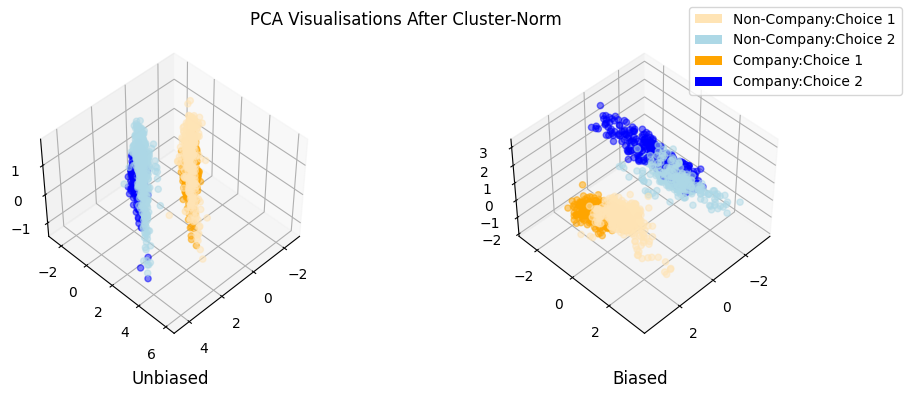

In [13]:
fig = plt.figure(figsize=(10, 4))
for i, template in enumerate(["unbiased", "biased"]):
    pos = t.load(f"activations/{model}/layer{layer}/{template}_correct.pt")
    neg = t.load(f"activations/{model}/layer{layer}/{template}_incorrect.pt")
    pos, neg = normalize_cluster(pos, neg, device=pos.device)
    pca = PCA(n_components=3)
    X = pca.fit_transform(pos - neg)
    ax = fig.add_subplot(1, 2, i+1, projection="3d")
    ax.view_init(elev=45, azim=45)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.5, c=colours)
    title = f"{template[0].upper()}{template[1:]}"
    ax.set_title(title, y=0, pad=-25, verticalalignment="top")
plt.suptitle("PCA Visualisations After Cluster-Norm")
plt.figlegend(handles=pca_legend_elements)
plt.tight_layout()
plt.show()

### ccs

CCS norm burns


fitting probes:   0%|          | 0/50 [00:00<?, ?it/s]/home/laurito/miniconda3/envs/cluster/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
fitting probes: 100%|██████████| 50/50 [53:00<00:00, 63.61s/it]


CCS norm burns


fitting probes: 100%|██████████| 50/50 [49:37<00:00, 59.55s/it]


CCS norm cluster


fitting probes: 100%|██████████| 50/50 [53:53<00:00, 64.67s/it]


CCS norm cluster


fitting probes: 100%|██████████| 50/50 [52:33<00:00, 63.07s/it]


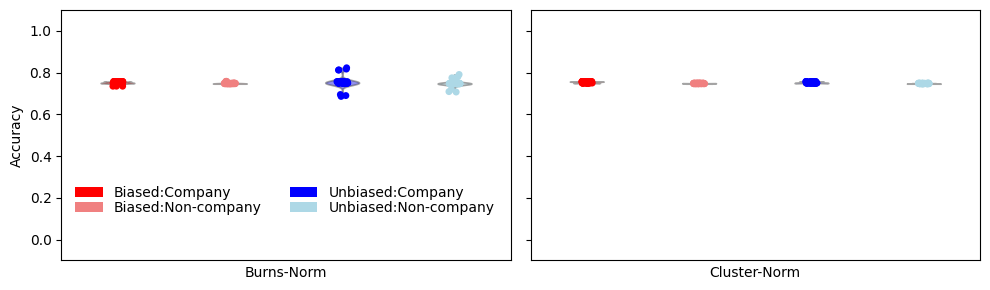

In [14]:
def get_ccs(normalize, perm):
    accuracies, templates = [], []
    for template in ["biased", "unbiased"]:
        pos = t.load(f"activations/{model}/layer{layer}/{template}_correct.pt")[perm]
        neg = t.load(f"activations/{model}/layer{layer}/{template}_incorrect.pt")[perm]
        ccs = CCS(
            pos=pos,
            neg=neg,
            normalize=normalize,
            n_probe=50,
            device=t.device("cuda")
        )
        ccs.optimize()
        for probe in ccs.probes:
            preds = ccs.predict(probe, pos, neg)
            c_acc = (preds[:1000] == labels[:1000]).mean()
            nc_acc = (preds[1000:] == labels[1000:]).mean()
            if (1-nc_acc) > nc_acc:
                nc_acc = 1-nc_acc
                c_acc = 1-c_acc
            accuracies.extend([c_acc, nc_acc])
            templates.extend([f"{template}-company", f"{template}-noncompany"])
    df = pd.DataFrame()
    df["template"] = templates
    df["accuracy"] = accuracies
    return df

perm = t.randperm(len(labels))
burns = get_ccs("burns", perm)
cluster = get_ccs("cluster", perm)

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, squeeze=True, figsize=(10, 3))
for ax, df, label in zip(axs, [burns, cluster], ["Burns-Norm", "Cluster-Norm"]):
    sns.stripplot(x="template", y="accuracy", data=df, jitter=0.05, ax=ax, palette=colours, hue="template")
    sns.violinplot(x="template", y="accuracy", data=df, ax=ax, palette=colours, hue="template",
                cut=0, inner=None, width=0.3, alpha=0.5)
    ax.set_xticks([], [])
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel(label)
axs[0].set_ylabel("Accuracy")
plt.figlegend(handles=legend_elements, loc="lower left", ncol=2, labelspacing=0.1,
              borderaxespad=5., frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()